<a href="https://colab.research.google.com/github/Shazaam91/Hate-Speech-Detection-/blob/main/Hate_Speech_Sinhala_BILSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!apt-get install fonts-noto
!pip install fasttext


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core fonts-noto-extra
  fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 49 not upgraded.
Need to get 317 MB of archives.
After this operation, 789 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:2022

In [2]:
# Download FastText model and clone FastText repository
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
!gzip -d cc.si.300.bin.gz
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText && sudo python setup.py install


--2024-09-04 04:43:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481477801 (459M) [binary/octet-stream]
Saving to: ‘cc.si.300.vec.gz’

cc.si.300.vec.gz    100%[===================>] 459.17M   180MB/s    in 2.6s    

2024-09-04 04:43:40 (180 MB/s) - ‘cc.si.300.vec.gz’ saved [481477801/481477801]

--2024-09-04 04:43:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181346570 (3.0G) [application/octet-stream]
Saving to: ‘cc.si

In [4]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.font_manager as fm
from collections import Counter
from nltk.tokenize import word_tokenize
from textblob import TextBlob

nltk.download('punkt')
plt.rcParams['font.family'] = 'Noto Sans Sinhala'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('sinhala-hate-speech-dataset.csv', encoding='utf-8')

In [7]:
df.head(10)

,id,comment,label
0,1,`හුදෙකලා´ එකේ `ද´ ඇහෙනවද කාටහරි,0
1,2,18ක පෙනුමක් තියෙන්නේ,0
2,3,2020 එනවා කිව්නාට මෙහෙම එයි කියලා හිතුවේ නෑ පට්ට,0
3,4,25 කැල්ල..හම්මෝ..,0
4,5,25 කෙල්ල අයියලගෙ කාලද කොහෙද ඉන්නෙ,1
5,6,25 ක් වගේ ???ඉතින් වැලලියන්,1
6,7,25 ලුක් එක දැකල ඔලුව සවුත්තු උන තරිදු...,0
7,8,25ක පෙනුමක් කියපු කෑල්ලේ ඉදන් බලන එක නතර කලා,0
8,9,33ක් ගුවන්තොටුපළවල ලෝකයේ හිරවෙලා ඉන්නවා ඩුබායි...,0
9,10,5 දෙනා කිව්වෙ මේ පස්දෙනාද..,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6345 entries, 0 to 6344
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6345 non-null   int64 
 1   comment  6345 non-null   object
 2   label    6345 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 148.8+ KB


In [9]:
df.describe()

,id,label
count,6345.000000,6345.000000
mean,3173.000000,0.544523
std,1831.788061,0.498053
min,1.000000,0.000000
25%,1587.000000,0.000000
50%,3173.000000,1.000000
75%,4759.000000,1.000000
max,6345.000000,1.000000


In [10]:
df.isnull().sum()

,0
id,0
comment,0
label,0


In [11]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning function to all comments
df['cleaned_comment'] = df['comment'].apply(clean_text)

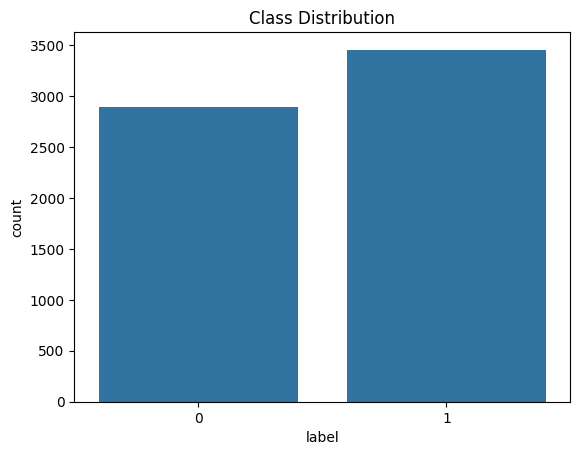

label
1    3455
0    2890
Name: count, dtype: int64


In [12]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Print the counts of each class
print(df['label'].value_counts())

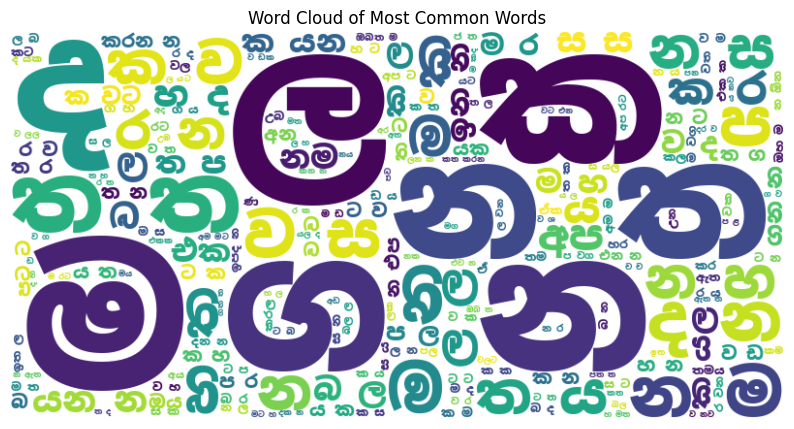

In [13]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/content/NotoSansSinhala-Black.ttf').generate(' '.join(df['comment']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


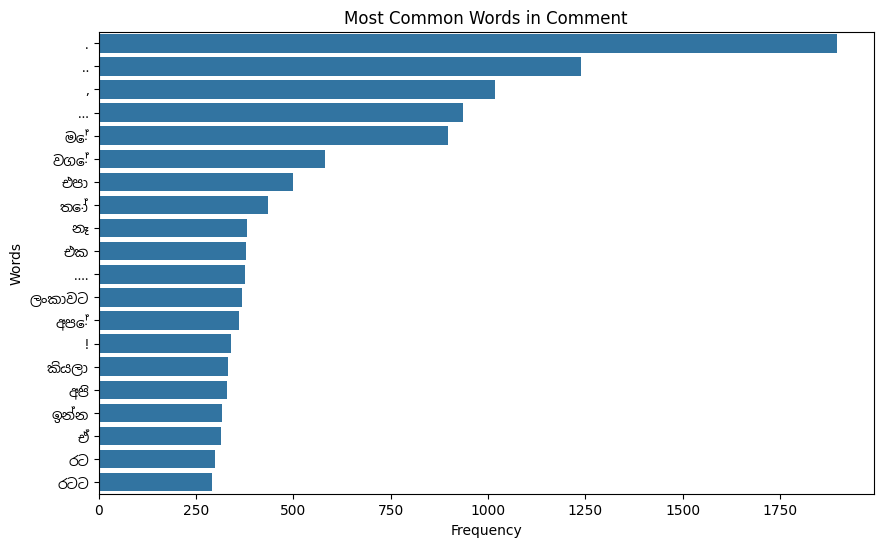

In [14]:
# Tokenize the posts
df['tokenized'] = df['comment'].apply(word_tokenize)

# Flatten the list of all words
all_words = [word for tokens in df['tokenized'] for word in tokens]

# Frequency distribution of the most common words
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words])
plt.title('Most Common Words in Comment')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Words')  # Y-axis label in English
plt.xticks()  # X-ticks in default font (English)
plt.yticks(fontproperties=sinhala_prop, fontsize=10, rotation=0, ha='right')  # Y-ticks in Sinhala font, aligned to the right

plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


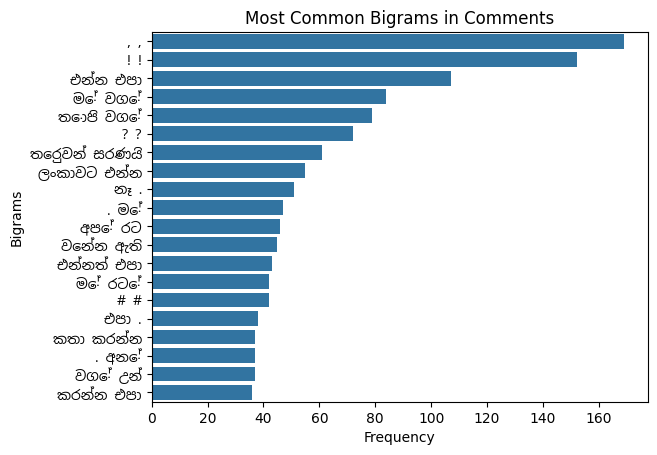

In [16]:
from nltk import ngrams

# Create bigrams
bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(bigrams).most_common(20)

# Set the font properties for Sinhala text
sinhala_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Regular.ttf')

# Plotting the most common bigrams
sns.barplot(x=[bigram[1] for bigram in bigram_freq], y=[' '.join(bigram[0]) for bigram in bigram_freq])

# Adding title and labels
plt.title('Most Common Bigrams in Comments')  # Title in English
plt.xlabel('Frequency')  # X-axis label in English
plt.ylabel('Bigrams')  # Y-axis label in English

# Adjust y-axis ticks for better visibility
plt.yticks(fontproperties=sinhala_prop, fontsize=10, ha='right', rotation=0)  # Y-ticks in Sinhala font, aligned to the right

plt.show()

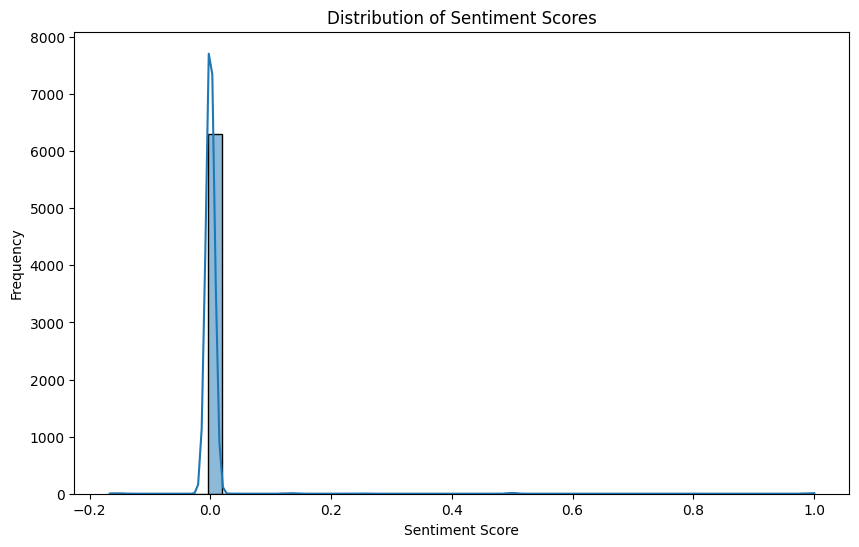

In [17]:
# Calculate sentiment polarity for each post
df['sentiment'] = df['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=50, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

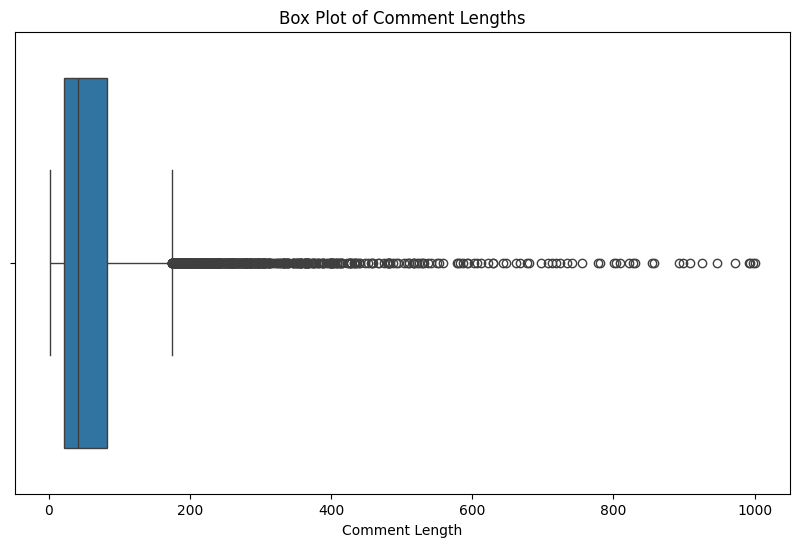

In [18]:
# Calculate the length of each comment
df['comment_length'] = df['comment'].apply(len)

# Plotting a box plot to detect outliers in comment lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['comment_length'])
plt.title('Box Plot of Comment Lengths')
plt.xlabel('Comment Length')
plt.show()

In [19]:
# Read dataset
dataset = []
with open('sinhala-hate-speech-dataset.csv', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        label = row['label']
        post = row['comment']
        item = [post]
        if label == '0':
            item.append(0)
        elif label == '1':
            item.append(1)
        else:
            print('ERROR: Unexpected label value')
            continue
        dataset.append(item)

# Extract posts and labels
posts, labels = zip(*dataset)
posts = list(posts)
labels = list(labels)

print(f"Number of records read: {len(dataset)}")
print(f"Length of posts: {len(posts)}")
print(f"Length of labels: {len(labels)}")

Number of records read: 6345
Length of posts: 6345
Length of labels: 6345


In [20]:
# Tokenize posts before resampling
tokenizer = Tokenizer()
tokenizer.fit_on_texts(posts)
sequences = tokenizer.texts_to_sequences(posts)
padded_sequences = pad_sequences(sequences, maxlen=120)

# Check lengths of padded_sequences and labels
print(f"Length of padded_sequences: {len(padded_sequences)}")
print(f"Length of labels: {len(labels)}")

Length of padded_sequences: 6345
Length of labels: 6345


In [21]:
# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
padded_sequences, labels = sm.fit_resample(padded_sequences, labels)

# Check class distribution after SMOTE
print(f"Length of padded_sequences after SMOTE: {len(padded_sequences)}")
print(f"Length of labels after SMOTE: {len(labels)}")

Length of padded_sequences after SMOTE: 6910
Length of labels after SMOTE: 6910


In [22]:
# Convert posts and labels to numpy arrays for consistency
posts = np.array(posts)
labels = np.array(labels)

In [23]:
# Trim the labels to match the length of posts
labels = labels[:len(posts)]

In [24]:
# Check the lengths after trimming
print(f"Length of posts after trimming: {len(posts)}")
print(f"Length of labels after trimming: {len(labels)}")

Length of posts after trimming: 6345
Length of labels after trimming: 6345


In [25]:
# split the text data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(posts, labels, test_size=0.1, random_state=42)

print(f"Training set size: {len(X_train_text)}, Test set size: {len(X_test_text)}")

Training set size: 5710, Test set size: 635


In [26]:
# Define parameters for tokenization and padding
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = ""

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Fit the tokenizer on the training text data
tokenizer.fit_on_texts(X_train_text)  # Ensure X_train_text is a list of texts

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)  # Ensure X_test_text is a list of texts

# Pad sequences to ensure consistent input length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, truncating=trunc_type)

# Output shapes of the padded sequences
print(f"Shape of padded training data: {X_train_padded.shape}")
print(f"Shape of padded testing data: {X_test_padded.shape}")

Shape of padded training data: (5710, 120)
Shape of padded testing data: (635, 120)


In [27]:
# Load FastText model
ft = fasttext.load_model('cc.si.300.bin')

# Define the embedding dimension
embedding_dim = 300  # Ensure this matches the FastText vector size

# Initialize the embedding matrix
embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Populate the embedding matrix
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:  # Skip words beyond vocab_size
        continue
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector


In [28]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(32, dropout=0.5)),
    layers.Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,000,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,000,300 (11.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,300 (11.45 MB)

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [31]:
num_epochs = 100

# Fit the model with training data and include the callbacks for early stopping and checkpointing
history = model.fit(
    X_train_padded,  # Use the padded training data
    y_train,         # Use the training labels
    validation_split=0.1,  # Use 10% of the training data for validation
    epochs=num_epochs,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.6316 - loss: 0.8568 - val_accuracy: 0.7881 - val_loss: 0.5149
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8001 - loss: 0.5011 - val_accuracy: 0.8319 - val_loss: 0.4549
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - accuracy: 0.8164 - loss: 0.4413 - val_accuracy: 0.8424 - val_loss: 0.4298
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.8171 - loss: 0.4273 - val_accuracy: 0.8371 - val_loss: 0.4089
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.8131 - loss: 0.4184 - val_accuracy: 0.8511 - val_loss: 0.3892
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.8378 - loss: 0.3946 - val_accuracy: 0.8266 - val_loss: 0.4042
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.8384 - loss: 0.3854 - val_accuracy: 0.8546 - val_loss: 0.3736
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.8409 -

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8625 - loss: 0.3355
Test Accuracy: 0.8724409341812134
Test Loss: 0.31658583879470825


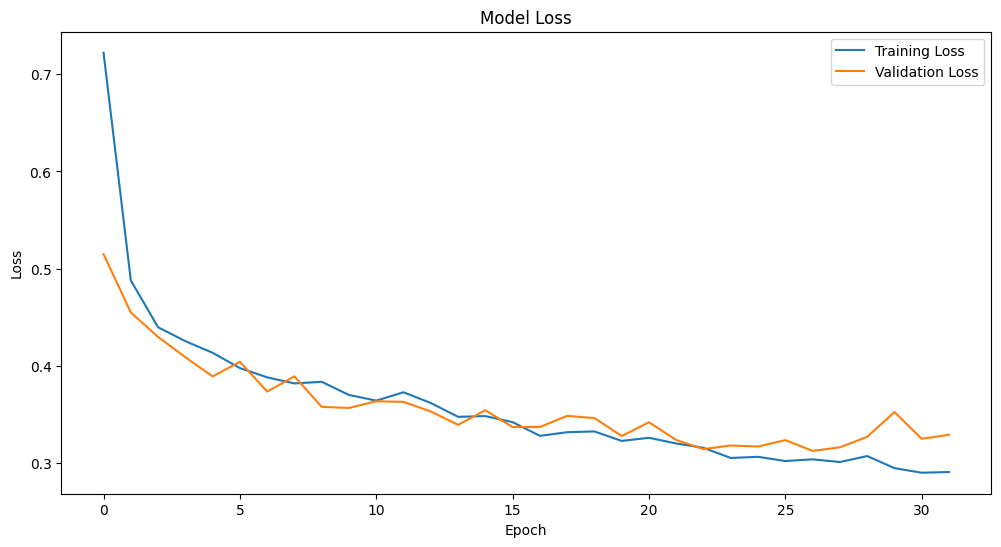

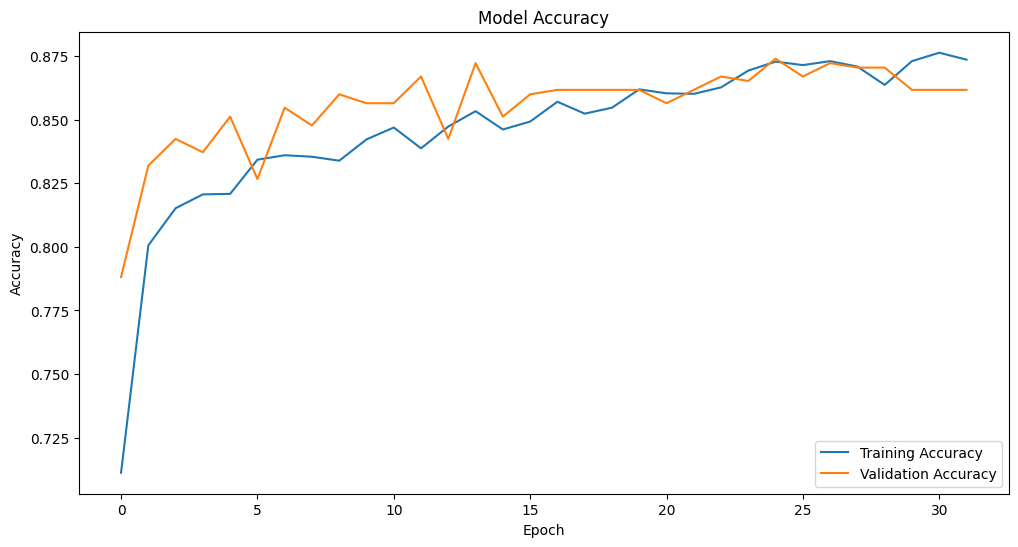

In [33]:
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [34]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, batch_size=32)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8625 - loss: 0.3355
Test Accuracy: 0.8724409341812134
Test Loss: 0.31658583879470825


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       300
           1       0.90      0.85      0.88       335

    accuracy                           0.87       635
   macro avg       0.87      0.87      0.87       635
weighted avg       0.87      0.87      0.87       635

Confusion Matrix:
[[269  31]
 [ 50 285]]


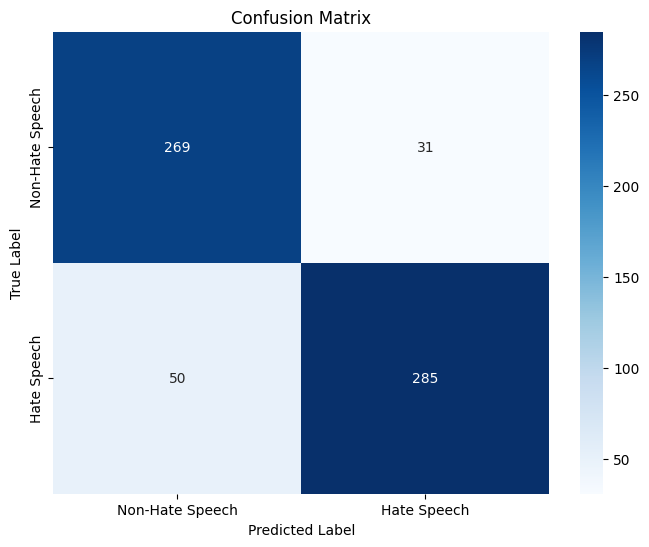

In [38]:
predictions = model.predict(X_test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Hate Speech', 'Hate Speech'], yticklabels=['Non-Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Saving the model Keras format
model.save('hate_speech_model.keras')

In [43]:
from tensorflow import keras

# Loading the model
loaded_model = keras.models.load_model('hate_speech_model.keras')

def predict_hate_speech(text, model, tokenizer, max_length, threshold=0.5):
    # Preprocess the input text
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    # Make a prediction
    prediction = model.predict(padded_sequences)

    # Determine the label with the adjusted threshold
    label = 'Hate Speech' if prediction[0] > threshold else 'Non-Hate Speech'
    confidence = float(prediction[0])

    return label, confidence


In [50]:
# Test Sinhala text
text = "ගිය ආණ්ඩුවත් මේ කාලකන්නි තිරිසන් මුස්ලිම් බල්ලාව අරක්ෂා කරා.... "

# Test the loaded model
label, score = predict_hate_speech(text, loaded_model, tokenizer, max_length=50)
print(f"Prediction: {label} (Confidence: {score:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: Hate Speech (Confidence: 0.84)


<ipython-input-43-dc078d4a6f30>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0])


In [51]:
from google.colab import files
files.download('hate_speech_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>